# Lernkurven und Parameterplots

Voraussetzungen:   
- Allgemeines Verständnis der Problemstellung beim supervised machine learning
- Insbesondere, dass das Ziel Verallgemeinerung ist, und die Gefahr das Overfitting
Die Lösung dieser Probleme besteht typischerweise in allgemeinen Prinzipien beim Vorgehen bei einem Klassifikationsproblem. Insbesondere muss fast immer zwingend: 
- jemand (Sie!) die Verantwortung übernehmen für ein korrektes Vorgehen beim Training. Diese Person wird auch Verallgemeinerungsaussagen gegenüber dem Auftragsteller verantworten müssen (z.B. dass das trainierte System auf neuen Daten mindestens eine Genauigkeit von 80% erreicht, o.ä.)
- sofort ein Testset ausgesondert werden, welches nur zu einem Zweck benutzt werden darf: Zur abschliessenden Beurteilung der Genauigkeit eines einzigen Klassifikators. 
- Alle weitere Arbeit wird auf den restlichen Daten vorgenommen. Diese werden oft wieder in ein Trainings- und ein Validierungsset eingeteilt (oft im Verhältnis 80%/20% o.ä.). Der Klassifikator erhält die Trainingsdaten um zu lernen. Die Validierungsdaten werden benutzt, um die Genauigkeit des Klassifikators zu messen. 
- Je öfter Sie die Ergebnisse auf dem Validierungsset anschauen und danach (mit dieser Einsicht) einen neuer Klassifikator trainieren, umso schlechter wird die Verallgemeinerungsfähigkeit der aus dem Validierungsdatensatz gezogenen Schlüsse. Diese Art der "Kontaminierung" der Validierungsdaten soll auf dem Testset so strikt wie möglich verhindert werden. 

**In diesem Notebook betrachten wir Methoden, um Parameter eines Klassifikators zu setzen. Präziser: Um aus einem Hypothesenset einen geeigneten Kandidaten auszuwählen, der nur so viel von den Trainings- und Validierungsdaten lernt, wie er auf das Testset verallgemeinern kann.**

In [4]:
import pandas as pd
import numpy as np
import sklearn
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
np.set_printoptions(precision=3)
%matplotlib inline

In [66]:
#Lade die Daten
#Die 'ID'-Spalte ist offensichtlich nur ein Index. Benutzen wir in ebenso:
data=pd.read_csv('./UCI_train.csv',index_col='ID')

# Allgemeiner Überblick

- Verschaffen Sie sich mit Pandas einen Überblick über den Datensatz. 
- Erstellen Sie ein Trainings- und ein Testdatensatz, Xtrain und Xtest, sowie die zugehörigen Zielvariable ytrain und ytest. 20% der Daten sollen ins Testset. Arbeiten Sie nur ansonsten möglichst nur mit dem Trainingsset (siehe allerletzte Frage in diesem Notebook: Sie wollen Ihre Verallgemeinerungsfähigkeit nicht gefährden!).

In [67]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [68]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
6,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,80000.0,1,2,2,34,2,2,2,2,2,...,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0,1
29996,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0


# KNN Parameterplot / Parameterplot

Parameterplots sind Plots, welche eine Qualitätsgrösse (einen Score) eines Klassifikators gegen den Wert eines seiner Hyperparameter zeigt. Daran kann oft ein guter Wert abgelesen werden. Sinnvollerweise wird der Score cross-validiert bestimmt, d.h. mit einem Unsicherheits-Band versehen. Eine Vorlage dafür findet sich hier:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

Aufgabe: Überprüfuen Sie, ob es sich lohnt, den nun folgenden Parameter-Plot um diese Unsicherheitsbänder zu verbessern. Können Sie die untenstehenden Zellen in eine for-Schleife verpacken?

In [69]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(knn,Xtrain,ytrain,scoresList,cvscoresList,cv=10):
    knn.fit(Xtrain,ytrain)
    scores=accuracy_score(knn.predict(Xtrain),ytrain)
    print("training accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    cvscores=cross_val_score(knn,Xtrain,ytrain,cv=cv)
    print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (cvscores.mean(), cvscores.std() * 2))
    scoresList.append(scores.mean())
    cvscoresList.append(cvscores.mean())
    return scoresList,cvscoresList

In [70]:
tal=[]
cval=[]
n_neighbors_list=[1,2,3,5,20,100,500]

In [71]:
data.columns[-1]

'default.payment.next.month'

In [72]:
df = data.drop(data.columns[-1], axis=1)
Xtrain = df.to_numpy()

ytrain = data[data.columns[-1]].to_numpy()

In [73]:
Xtrain

array([[2.000e+04, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.200e+05, 2.000e+00, 2.000e+00, ..., 1.000e+03, 0.000e+00,
        2.000e+03],
       [9.000e+04, 2.000e+00, 2.000e+00, ..., 1.000e+03, 1.000e+03,
        5.000e+03],
       ...,
       [1.500e+05, 1.000e+00, 3.000e+00, ..., 1.290e+02, 0.000e+00,
        0.000e+00],
       [3.000e+04, 1.000e+00, 2.000e+00, ..., 4.200e+03, 2.000e+03,
        3.100e+03],
       [8.000e+04, 1.000e+00, 3.000e+00, ..., 1.926e+03, 5.296e+04,
        1.804e+03]])

In [74]:
ytrain

array([1, 1, 0, ..., 0, 1, 1])

In [75]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[0])
knn.fit(Xtrain,ytrain)
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 1.00 (+/- 0.00)
Cross-validation accuracy: 0.70 (+/- 0.02)


In [76]:
from sklearn.metrics import accuracy_score
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[1])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.84 (+/- 0.00)
Cross-validation accuracy: 0.76 (+/- 0.01)


In [77]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[2])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.84 (+/- 0.00)
Cross-validation accuracy: 0.73 (+/- 0.02)


In [78]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[3])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.82 (+/- 0.00)
Cross-validation accuracy: 0.75 (+/- 0.02)


In [79]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[4])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.79 (+/- 0.00)
Cross-validation accuracy: 0.78 (+/- 0.01)


In [80]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[5])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.78 (+/- 0.00)
Cross-validation accuracy: 0.78 (+/- 0.01)


In [81]:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors_list[6])
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.78 (+/- 0.00)
Cross-validation accuracy: 0.78 (+/- 0.00)


<ipython-input-82-b8362b829c23>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_neighbors_list)


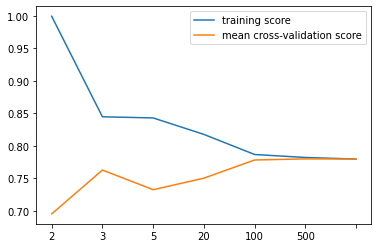

In [82]:
ax=plt.subplot(1,1,1)
ax.plot(np.arange(len(tal)),tal,label='training score');
ax.plot(np.arange(len(cval)),cval,label='mean cross-validation score');
ax.set_xticklabels(n_neighbors_list)
plt.legend();

In [57]:
#Bestes Resultat mit KNN:
knn=sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)
tal,cval=evaluate_accuracy(knn,Xtrain,ytrain,tal,cval)

training accuracy 0.84 (+/- 0.00)
Cross-validation accuracy: 0.76 (+/- 0.01)


# KNN Lernkurve für $k=20$

Lernkurven zeigen, wie gut sich ein Klassifikator verbessert, wenn er mehr Daten zum trainieren erhält. Lernkurven sind Plots des Scores (z.B. der Genauigkeit) gegen die Grösse des Trainingssets.

In [106]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_scores_mean)
    print(test_scores_mean)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [92]:
np.logspace(-4, -1, 10)

array([0.   , 0.   , 0.   , 0.001, 0.002, 0.005, 0.01 , 0.022, 0.046,
       0.1  ])

In [83]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [84]:
np.logspace(-8, -7, 20)

array([1.000e-08, 1.129e-08, 1.274e-08, 1.438e-08, 1.624e-08, 1.833e-08,
       2.069e-08, 2.336e-08, 2.637e-08, 2.976e-08, 3.360e-08, 3.793e-08,
       4.281e-08, 4.833e-08, 5.456e-08, 6.158e-08, 6.952e-08, 7.848e-08,
       8.859e-08, 1.000e-07])

In [100]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

[0.001 0.002 0.003 0.005 0.008 0.013 0.022 0.036 0.06  0.1  ]
[0.85  0.846 0.909 0.832 0.878 0.849 0.834 0.839 0.849 0.839]
[0.738 0.75  0.719 0.741 0.717 0.693 0.683 0.712 0.715 0.718]


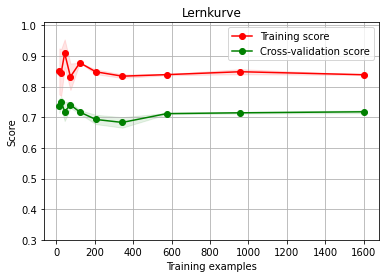

In [119]:
estimator = KNeighborsClassifier(n_neighbors=3)
#estimator = DecisionTreeClassifier(max_depth=5)
#estimator = SVC(kernel="linear", C=0.025)
#estimator = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
#estimator = MLPClassifier(alpha=1, max_iter=1000)
#estimator = GaussianNB()
print(np.logspace(-3, -1, 10))

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(estimator, "Lernkurve", Xtrain, ytrain, train_sizes=np.logspace(-3, -1, 10), ylim=(0.3, 1.01), n_jobs=4);

Es interessiert nun:  
- Was bedeuten die Kurven? 
- Welchen Einfluss hat die Grösse des Trainingssets?
- Wie verändern sie sich? Z.B. bei Veränderung von N (n_neighbors), dem Plot Range, dem Cross-Validation-Parameter etc.
- Welche Ihrer Eigenschaften können Sie erklären? Sollte z.B. die Trainingskurve immer über der Testkurve liegen?
- Was passiert bei wenn N=1 (Anzahl nearest neighbours)?  
-> je kleiner die n - Zahl, desto höher ist das Overfitting
- Liegt ein Overfitting vor?

** Finden Sie einen geeigneten Klassifikator. Deckt er sich mit dem im ParameterSearch gefundenen?**  
** Welche Verallgemeinerungsgenauigkeit werden Sie Ihrem Auftraggeber versprechen?**

In [120]:
-> Abgabe: kurze Beantwortung der Fragen des jetzigen ipynb

SyntaxError: invalid syntax (<ipython-input-120-2913d0b643ed>, line 1)